# AMIA 2016 Annual Symposium Workshop (WG13)

## Automated and Scalable Cloud-based RNA-Seq Data Analysis, Part IV


Riyue Bao, Ph.D. 
Center for Research Informatics,
The University of Chicago.
November 13, 2016

***

## Objective

* Learn the background and application of The Cancer Genome Atlas (TCGA)
* Learn the structure and access of Genomics Data Commons (GDC)
* Explore datasets hosted on GDC
* Practice how to associate gene expression with clincial data

***

## Dataset

Genomics Data Commons (GDC), Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC), Expression and Clinical data
<https://gdc-portal.nci.nih.gov>

***

## Associate gene expression with clincial outcome: Survival Analysis

Commonly used tool / package for survival include `survival`.

In this workshop, We will demo how to use `survival` to identify if PRDM11 gene expression is a prognosis factor of DLBC.

***

### Clean the environment

In [1]:
rm(list=ls())

### Start the clock!

In [2]:
ptm = proc.time()

### Load libraries / packages

In [3]:
##-- List packages required in this analysis
cpan.pkg.list = c('')
bioc.pkg.list = c('survival')

##-- Load libraries
for(pkg in c(cpan.pkg.list, bioc.pkg.list)) {
    print(pkg)
    suppressMessages(require(pkg, character.only = TRUE))
}

[1] ""
[1] "survival"


### Set up global parameters, input/output directories and files

In [4]:
##-- Parameters
cancer = 'DLBC' 
study = paste0('TCGA_', cancer)
group.key = 'PRDM11.2group'
outcome.key = 'overall.survival'
time.unit = 'Days'
clinical.fields = c('bcr.patient.barcode','gender','race','ethnicity',
                    'age.at.initial.pathologic.diagnosis',
                    'histological.type','clinical.stage',
                    'vital.status','overall.survival',
                    'PRDM11','MYC')

##-- Set up working directory
work.dir = '.'
setwd(work.dir)

##-- Input/Output directories
in.dir = 'input'
out.dir = 'output'

##-- Input/Output files
clinical.file = 'TCGA_DLBC.clinical.txt'

### Print analysis info

In [5]:
print(paste0('Cancer = ', cancer))
print(paste0('Group keys = ', group.key))
print(paste0('Outcome keys = ', outcome.key))
print(paste0('Clinical file  = ', clinical.file))

[1] "Cancer = DLBC"
[1] "Group keys = PRDM11.2group"
[1] "Outcome keys = overall.survival"
[1] "Clinical file  = TCGA_DLBC.clinical.txt"


### Import data files

In [6]:
##-- Clinical table with PRDM11 expression
data.clinical = read.delim(paste0(in.dir, '/', clinical.file), 
                           header = T, stringsAsFactors = F)

### Preprocess data: Clinical and Expression data

In [7]:
##-- Select clinical fields of interest
clinical = data.clinical[,clinical.fields]
colnames(clinical) = gsub('bcr.patient.barcode', 'patient', 
                      gsub('age.at.initial.pathologic.diagnosis',
                               'age',
                      gsub('histological.type', 'histology', 
                      gsub('clinical.stage', 'stage', 
                      gsub('vital.status','dead',
                           colnames(clinical))))))
# colnames(clinical)

##-- Add right censoring
# table(clinical$dead)
clinical$dead = as.numeric(gsub('Dead', 1, 
                                gsub('Alive', 0, 
                                     clinical$dead)))

##-- Filter clinical 
# dim(clinical)
hist = 'Diffuse large B-cell lymphoma (DLBCL) NOS (any anatomic site nodal or extranodal)'
races = c('BLACK OR AFRICAN AMERICAN')
clinical = clinical[clinical$histology == hist &
                    ! clinical$race %in% races,]

##-- Add expression quartile for PRDM11 gene
clinical = within(clinical, 
                  PRDM11.quartile <- as.integer(cut(PRDM11, 
                  quantile(PRDM11, probs=0:4/4), 
                     include.lowest=TRUE)))
clinical$PRDM11.2group = gsub(1, 'low', 
                              gsub(2, 'low', 
                                   gsub(3, 'low', 
                                        gsub(4, 'high', 
                                             clinical$PRDM11.quartile))))

# detach(clinical)
attach(clinical)

##-- Peek into the table ready for survival analysis
clinical[1:3,]

patient,gender,race,ethnicity,age,histology,stage,dead,overall.survival,PRDM11,MYC,PRDM11.quartile,PRDM11.2group
TCGA-FA-8693,MALE,WHITE,NOT HISPANIC OR LATINO,75,Diffuse large B-cell lymphoma (DLBCL) NOS (any anatomic site nodal or extranodal),Stage I,0,35,2.771738,10.05316,2,low
TCGA-FA-A4BB,MALE,WHITE,NOT HISPANIC OR LATINO,67,Diffuse large B-cell lymphoma (DLBCL) NOS (any anatomic site nodal or extranodal),Stage IV,0,-10,2.716793,10.40252,2,low
TCGA-FA-A4XK,MALE,ASIAN,NOT HISPANIC OR LATINO,40,Diffuse large B-cell lymphoma (DLBCL) NOS (any anatomic site nodal or extranodal),Stage II,0,62,3.571446,10.84071,3,low


### Run survival analysis

[1] "PRDM11.2group,overall.survival"


sample.group,Freq
high,10
low,30


Call: survfit(formula = surv ~ sample.group)

                   n events median 0.95LCL 0.95UCL
sample.group=high 10      1   6425      NA      NA
sample.group=low  30      3     NA      NA      NA

Call:
survdiff(formula = surv ~ sample.group)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
sample.group=high 10        1     1.95     0.459      1.38
sample.group=low  30        3     2.05     0.435      1.38

 Chisq= 1.4  on 1 degrees of freedom, p= 0.24 

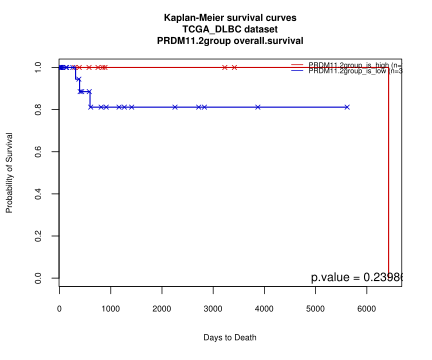

In [8]:
##-- Set up R plot display options in notebook
options(jupyter.plot_mimetypes = "image/svg+xml") 
options(repr.plot.width = 6, repr.plot.height = 5)

##-- Survival: Specify factor of interest and outcome
print(paste0(group.key, ',', outcome.key))

##-- Factor
sample.group = PRDM11.2group

##-- Outcome
outcome = overall.survival
censor = dead

sample.counts = data.frame(table(sample.group))
sample.counts

if(nrow(sample.counts) <= 1) {
  break
}

##-- Survival: 
surv = Surv(outcome, censor)
surv.fit = survfit(surv ~ sample.group)
surv.fit

groups = gsub('sample.group=', '', names(surv.fit$strata))
counts = surv.fit$n

##-- Survival: log-rank test
surv = Surv(outcome, censor)
surv.diff = survdiff(surv ~ sample.group)
surv.diff
p.val = 1 - pchisq(surv.diff$chisq, length(surv.diff$n) - 1)
p.val = round(p.val, digits = 5)

##-- Survival: Plot KM
sample.colors = c('#CC0000', '#0000CC')
plot.title = paste0('Kaplan-Meier survival curves\n',
                    study, ' dataset\n',
                    group.key, ' ', outcome.key)
x.title = paste0(time.unit, ' to Death')
y.title = 'Probability of Survival'

labels = c()
for(i in 1:length(groups)) {
  labels = c(labels,
             paste0(group.key, '_is_', groups[i],
                    ' (n=', surv.fit$n[i],')'))
}

output = paste0(out.dir, '/', clinical.file, '.', 
                group.key, '.',outcome.key, '.KMplot.pdf')

# pdf(file=output, width=5, height=4)
plot(surv.fit, mark=4, col=sample.colors, 
     lty=1, lwd=1.5,cex=0.8,cex.lab=0.7, cex.axis=0.7, cex.main=0.8,
     main=plot.title,
     xlab=x.title, 
     ylab=y.title)
legend(x='topright',legend=labels, cex=0.6, col=sample.colors, 
       lty=1, bty = "n")
legend(x = 'bottomright', border=NULL, 
       legend=paste0('p.value = ', p.val), col='black', bty = "n")
# dev.off()

## Associate gene expression with clincial outcome: Survival Analysis - End

### Stop the clock!

In [9]:
proc.time() - ptm

   user  system elapsed 
  1.378   0.053   1.493 

In [10]:
print('Program run finished!')

##-- Print analysis environment (for reproducible research)
sessionInfo()

[1] "Program run finished!"


R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.5 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] survival_2.39-5

loaded via a namespace (and not attached):
 [1] lattice_0.20-34    digest_0.6.10      crayon_1.3.2       IRdisplay_0.4.9000
 [5] repr_0.9.9000      grid_3.3.1         R6_2.2.0           jsonlite_1.1      
 [9] magrittr_1.5       evaluate_0.10      stringi_1.1.2      uuid_0.1-2        
[13] Matrix_1.2-7.1     IRkernel_0.7       splines_3.3.1      tools_3.3.1       
[17] stringr_1.1.0    